In [ ]:
#GEE Authentication and Initialization

In [10]:
import ee
import geemap

In [82]:
ee.Authenticate()
ee.Initialize(project='fleet-hawk-463015-h5')

In [ ]:
#feature Collection Functions:

In [ ]:
#ndwi from a point+Area Calculation

In [124]:
#------------Final Detect_lake_from_point------------#ddd
import ee
import pandas as pd


def detect_lake_from_point(point, year, search_radius=3000, ndwi_thresh=0.25):
    aoi = point.buffer(search_radius)

    def mask_landsat_clouds(img):
        qa = img.select('QA_PIXEL')
        cloud        = 1 << 3
        cloud_shadow = 1 << 4
        snow         = 1 << 5
        mask = (qa.bitwiseAnd(cloud).eq(0)
                  .And(qa.bitwiseAnd(cloud_shadow).eq(0))
                  .And(qa.bitwiseAnd(snow).eq(0)))
        return img.updateMask(mask)

    def scale_sr(img):
        optical = img.select('SR_B[0-9]*').multiply(0.0000275).add(-0.2)
        return img.addBands(optical, overwrite=True)

    # --- NDWI depending on collection ---
    def add_ndwi(img, sensor):
        if sensor in ["LC08", "LC09"]:   # Landsat 8/9
            green, nir = 'SR_B3', 'SR_B5'
        else:                            # Landsat 5/7
            green, nir = 'SR_B2', 'SR_B4'
        ndwi = img.normalizedDifference([green, nir]).rename('NDWI')
        return img.addBands(ndwi)


    # --- Choose the correct Landsat collection ---
    def get_collection_id(y):
        if y <= 2011:
            return "LANDSAT/LT05/C02/T1_L2"   # Landsat 5
        elif y == 2012:
            return "LANDSAT/LE07/C02/T1_L2"   # Landsat 7
        else:
            return "LANDSAT/LC08/C02/T1_L2"   # Landsat 8/9

    def get_fall_collection(y):
        coll_id = get_collection_id(y)
        sensor = coll_id.split("/")[1][:4]  # e.g. LC08, LT05, LE07
        return (ee.ImageCollection(coll_id)
            .filterDate(f"{y}-08-01", f"{y}-12-31")
            .filterBounds(aoi)
            .map(mask_landsat_clouds)
            .map(scale_sr)
            .map(lambda img: add_ndwi(img, sensor)))

    # --- Combine 3 years ---
    collection = (get_fall_collection(year-1)
                  .merge(get_fall_collection(year))
                  .merge(get_fall_collection(year+1)))

    if collection.size().getInfo() == 0:
        return {'lake_fc': ee.FeatureCollection([]), 'Lake_area_calculated_ha': None}

    # --- Median composite ---
    ndwi_median = collection.select('NDWI').median().clip(aoi)
    water_mask = ndwi_median.gt(ndwi_thresh)

    lake_fc_all = water_mask.selfMask().reduceToVectors(
        geometry=aoi,
        scale=30,
        geometryType='polygon',
        reducer=ee.Reducer.countEvery(),
        maxPixels=1e13
    )

    def add_area(f):
        return f.set('Lake_area_calculated_ha', f.geometry().area(maxError=1).divide(1e4))
    lake_fc_all = lake_fc_all.map(add_area)

    largest = ee.Feature(lake_fc_all.sort('Lake_area_calculated_ha', False).first())

    return {
        'lake_fc': ee.Algorithms.If(
            largest,
            ee.FeatureCollection([largest]),
            ee.FeatureCollection([])
        ),
        'Lake_area_calculated_ha': ee.Algorithms.If(largest, largest.get('Lake_area_calculated_ha'), None),
        'ndwi_median': ndwi_median
    }


In [20]:
#Lake Expansion 

In [21]:
def expansion_rate(point, ref_year, search_radius=3000, ndwi_thresh=0.3):
    """
    Calculate 10-year expansion rate of a non-GLOF lake (ha/year).

    - ref_year: e.g., 2020
    - recent window: (ref_year-1, ref_year, ref_year+1)
    - past window:   (ref_year-11, ref_year-10, ref_year-9)
    - search_radius default set to 3000 m
    """
    
    # --- Recent ---
    recent = detect_lake_from_point(point, ref_year,
                                    search_radius=search_radius,
                                    ndwi_thresh=ndwi_thresh)
    area_recent = recent["area_ha"].getInfo() if recent["area_ha"] else None
    
    # --- Past (10 years earlier) ---
    past_year = ref_year - 10
    past = detect_lake_from_point(point, past_year,
                                  search_radius=search_radius,
                                  ndwi_thresh=ndwi_thresh)
    area_past = past["area_ha"].getInfo() if past["area_ha"] else None
    
    # --- Expansion rate ---
    if area_recent is None or area_past is None:
        print(f"[{ref_year}] Could not compute area(s). "
              f"Recent={area_recent}, Past={area_past}")
        return None
    
    Expansion_rate = (area_recent - area_past) / 10.0   # ha per year
    
    # --- Print for checking ---
    print(f"Ref year {ref_year}: Past={area_past:.2f} ha | "
          f"Recent={area_recent:.2f} ha | "
          f"Expansion={rate:.2f} ha/yr")
    
    return Expansion_rate, area_recent, area_past

In [ ]:
#add to Pandas Dataframe functions

In [71]:
import pandas as pd
df_pre_enrich=pd.read_csv("df_final_with_laketypesorted_pre.csv")
df_pre_enrich.head(10)

,Lake_type,Longitude,Latitude,Year_final,Lake_area_ha,Elevation_m,GLOF,Lake_type_simplified,is_supraglacial
0,water pocket,74.609,42.522,1984,NaN,3466,1,other,0
1,ice,79.846,42.207,1984,NaN,3269,1,ice,0
2,ice,77.193,35.677,1984,NaN,4779,1,ice,0
3,water pocket,83.967,29.307,1985,NaN,4594,1,other,0
4,water pocket,74.633,36.039,1985,NaN,3301,1,other,0
5,moraine,76.867,41.975,1985,NaN,3627,1,moraine,0
6,moraine,86.586,27.874,1985,NaN,4368,1,moraine,0
7,ice,79.846,42.207,1985,NaN,3269,1,ice,0
8,water pocket,74.879,36.414,1986,NaN,2501,1,other,0
9,water pocket,88.027,27.586,1986,NaN,4437,1,other,0


In [72]:
df_subset = df_pre_enrich.iloc[0:50]   # rows 0–49 (i.e., 1–50 if you’re counting from 1)


In [74]:
df_subset.head(5)

,Lake_type,Longitude,Latitude,Year_final,Lake_area_ha,Elevation_m,GLOF,Lake_type_simplified,is_supraglacial
0,water pocket,74.609,42.522,1984,NaN,3466,1,other,0
1,ice,79.846,42.207,1984,NaN,3269,1,ice,0
2,ice,77.193,35.677,1984,NaN,4779,1,ice,0
3,water pocket,83.967,29.307,1985,NaN,4594,1,other,0
4,water pocket,74.633,36.039,1985,NaN,3301,1,other,0


In [153]:
import ee

# 100% server-side function for nonglof lakes
def detect_lake_from_point(point, year, search_radius=3000, ndwi_thresh=0.25):
    """
    Detect lake polygons around a point for a given year using Landsat NDWI.
    
    Args:
        point: ee.Geometry.Point
        year: ee.Number or int (Year_final)
        search_radius: buffer radius around point (m)
        ndwi_thresh: NDWI threshold for water detection
    
    Returns:
        ee.Feature with geometry = largest detected lake polygon (or the point if none)
        property: 'Lake_area_calculated_ha'
    """
    point = ee.Geometry(point)
    year  = ee.Number(year).toInt()
    aoi   = point.buffer(search_radius)

    # --- Cloud mask ---
    def mask_landsat_clouds(img):
        qa = img.select('QA_PIXEL')
        cloud        = 1 << 3
        cloud_shadow = 1 << 4
        snow         = 1 << 5
        mask = (qa.bitwiseAnd(cloud).eq(0)
                  .And(qa.bitwiseAnd(cloud_shadow).eq(0))
                  .And(qa.bitwiseAnd(snow).eq(0)))
        return img.updateMask(mask)

    # --- Scale reflectance ---
    def scale_sr(img):
        optical = img.select('SR_B[0-9]*').multiply(0.0000275).add(-0.2)
        return img.addBands(optical, overwrite=True)

    # --- Add NDWI ---
    def add_ndwi(img, use_l8_like):
        green = ee.Image(ee.Algorithms.If(use_l8_like, img.select('SR_B3'), img.select('SR_B2')))
        nir   = ee.Image(ee.Algorithms.If(use_l8_like, img.select('SR_B5'), img.select('SR_B4')))
        ndwi  = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
        return img.addBands(ndwi)

    # --- Get fall Landsat collection ---
    def get_fall_collection(y_num):
        y_num      = ee.Number(y_num).toInt()
        use_l8_like = y_num.gte(2013)  # True for L8/L9

        coll = ee.ImageCollection(ee.Algorithms.If(
            y_num.lte(2011),
            ee.ImageCollection('LANDSAT/LT05/C02/T1_L2'),
            ee.Algorithms.If(
                y_num.eq(2012),
                ee.ImageCollection('LANDSAT/LE07/C02/T1_L2'),
                ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .merge(ee.ImageCollection('LANDSAT/LC09/C02/T1_L2'))
            )
        ))

        start = ee.Date.fromYMD(y_num, 8, 1)
        end   = ee.Date.fromYMD(y_num, 12, 31)

        return (coll
                .filterDate(start, end)
                .filterBounds(aoi)
                .map(mask_landsat_clouds)
                .map(scale_sr)
                .map(lambda im: add_ndwi(im, use_l8_like)))

    # --- Build 3-year composite ---
    collection = (get_fall_collection(year.subtract(1))
                  .merge(get_fall_collection(year))
                  .merge(get_fall_collection(year.add(1))))

    # Guard: empty collections
    ndwi_median = ee.Algorithms.If(
        collection.size().gt(0),
        collection.select('NDWI').median().clip(aoi),
        ee.Image.constant(0).rename('NDWI').clip(aoi)
    )
    ndwi_median = ee.Image(ndwi_median)
    water_mask  = ndwi_median.gt(ndwi_thresh)

    # --- Vectorize ---
    lake_fc_all = water_mask.selfMask().reduceToVectors(
        geometry=aoi,
        scale=30,
        geometryType='polygon',
        reducer=ee.Reducer.countEvery(),
        maxPixels=1e13
    )

    def set_area(feat):
        area_ha = feat.geometry().area(maxError=1).divide(1e4)
        return feat.set('Lake_area_calculated_ha', area_ha)

    lake_fc_all = lake_fc_all.map(set_area)

    # --- Pick largest polygon or return point ---
    largest = ee.Feature(ee.Algorithms.If(
        lake_fc_all.size().gt(0),
        lake_fc_all.sort('Lake_area_calculated_ha', False).first(),
        ee.Feature(point, {'Lake_area_calculated_ha': None})
    ))

    return largest





In [29]:
import ee

# 100% server-side function for PRE-GLOF lakes
def detect_lake_pre_glof(point, year, search_radius=3000, ndwi_thresh=0.25):
    """
    Detect PRE-GLOF lake polygons around a point for years leading up to GLOF.
    
    Args:
        point: ee.Geometry.Point
        year: ee.Number or int (Year_final, i.e., event year)
        search_radius: buffer radius around point (m)
        ndwi_thresh: NDWI threshold for water detection
    
    Returns:
        ee.Feature with geometry = largest detected lake polygon (or the point if none)
        property: 'Lake_area_calculated_ha'
    """
    point = ee.Geometry(point)
    year  = ee.Number(year).toInt()
    aoi   = point.buffer(search_radius)

    # --- Cloud mask ---
    def mask_landsat_clouds(img):
        qa = img.select('QA_PIXEL')
        cloud        = 1 << 3
        cloud_shadow = 1 << 4
        snow         = 1 << 5
        mask = (qa.bitwiseAnd(cloud).eq(0)
                  .And(qa.bitwiseAnd(cloud_shadow).eq(0))
                  .And(qa.bitwiseAnd(snow).eq(0)))
        return img.updateMask(mask)

    # --- Scale reflectance ---
    def scale_sr(img):
        optical = img.select('SR_B[0-9]*').multiply(0.0000275).add(-0.2)
        return img.addBands(optical, overwrite=True)

    # --- Add NDWI ---
    def add_ndwi(img, use_l8_like):
        green = ee.Image(ee.Algorithms.If(use_l8_like, img.select('SR_B3'), img.select('SR_B2')))
        nir   = ee.Image(ee.Algorithms.If(use_l8_like, img.select('SR_B5'), img.select('SR_B4')))
        ndwi  = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
        return img.addBands(ndwi)

    # --- Get fall Landsat collection ---
    def get_fall_collection(y_num):
        y_num      = ee.Number(y_num).toInt()
        use_l8_like = y_num.gte(2013)  # True for L8/L9

        coll = ee.ImageCollection(ee.Algorithms.If(
            y_num.lte(2011),
            ee.ImageCollection('LANDSAT/LT05/C02/T1_L2'),
            ee.Algorithms.If(
                y_num.eq(2012),
                ee.ImageCollection('LANDSAT/LE07/C02/T1_L2'),
                ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .merge(ee.ImageCollection('LANDSAT/LC09/C02/T1_L2'))
            )
        ))

        start = ee.Date.fromYMD(y_num, 8, 1)
        end   = ee.Date.fromYMD(y_num, 12, 31)

        return (coll
                .filterDate(start, end)
                .filterBounds(aoi)
                .map(mask_landsat_clouds)
                .map(scale_sr)
                .map(lambda im: add_ndwi(im, use_l8_like)))

    # --- Build PRE-GLOF 3-year composite (y-3, y-2, y-1) ---
    collection = (get_fall_collection(year.subtract(3))
                  .merge(get_fall_collection(year.subtract(2)))
                  .merge(get_fall_collection(year.subtract(1))))

    # Guard: empty collections
    ndwi_median = ee.Algorithms.If(
        collection.size().gt(0),
        collection.select('NDWI').median().clip(aoi),
        ee.Image.constant(0).rename('NDWI').clip(aoi)
    )
    ndwi_median = ee.Image(ndwi_median)
    water_mask  = ndwi_median.gt(ndwi_thresh)

    # --- Vectorize ---
    lake_fc_all = water_mask.selfMask().reduceToVectors(
        geometry=aoi,
        scale=30,
        geometryType='polygon',
        reducer=ee.Reducer.countEvery(),
        maxPixels=1e13
    )

    def set_area(feat):
        area_ha = feat.geometry().area(maxError=1).divide(1e4)
        return feat.set('Lake_area_calculated_ha', area_ha)

    lake_fc_all = lake_fc_all.map(set_area)

    # --- Pick largest polygon or return point ---
    largest = ee.Feature(ee.Algorithms.If(
        lake_fc_all.size().gt(0),
        lake_fc_all.sort('Lake_area_calculated_ha', False).first(),
        ee.Feature(point, {'Lake_area_calculated_ha': None})
    ))

    return largest


In [5]:
def df_to_fc(df):
    features = []
    for idx, row in df.iterrows():
        point = ee.Geometry.Point([row["Longitude"], row["Latitude"]])

        # Convert row to dict, replace NaN with None
        props = row.where(pd.notnull(row), None).to_dict()
        props["id"] = int(idx)  # unique id for merging later

        features.append(ee.Feature(point, props))
    return ee.FeatureCollection(features)




In [6]:
def detect_area_nonglof(feature):
    point = feature.geometry()
    year  = ee.Number.parse(feature.get("Year_final")).toInt()
    lake  = detect_lake_from_point(point, year)

    # Return the lake feature, with all original properties copied,
    # and explicitly keep the calculated area
    return ee.Feature(lake).copyProperties(feature).set(
        'Lake_area_calculated_ha', lake.get('Lake_area_calculated_ha')
    )



In [7]:
def detect_area_glof(feature):
    point = feature.geometry()
    year  = ee.Number.parse(feature.get("Year_final")).toInt()
    lake  = detect_lake_pre_glof(point, year)

    # Return the lake feature, with all original properties copied,
    # and explicitly keep the calculated area
    return ee.Feature(lake).copyProperties(feature).set(
        'Lake_area_calculated_ha', lake.get('Lake_area_calculated_ha')
    )


In [8]:
pd.set_option('display.max_rows', None)

In [206]:
#split to 2 dataframe:
df_pos = df_pre_enrich[df_pre_enrich["GLOF"] == 1].copy()  # GLOF lakes
df_neg = df_pre_enrich[df_pre_enrich["GLOF"] == 0].copy()  # Non-GLOF lakes


In [181]:
#Assigning area to neg lakes:
df_neg_50=df_neg.iloc[0:50].copy()
fc = df_to_fc(df_neg_50)
fc_with_area = fc.map(detect_area_nonglof)

data = fc_with_area.getInfo()["features"]
rows = [f["properties"] for f in data]
df_neg_50_area = pd.DataFrame(rows)
df_neg_50_area.head()

,Elevation_m,GLOF,Lake_area_calculated_ha,Lake_area_ha,Lake_type,Lake_type_simplified,Latitude,Longitude,Year_final,count,id,is_supraglacial,label
0,4256,0,19.373351,11.23,M(e),moraine,36.412,72.901,2019,268,241,0,1
1,4618,0,18.463383,21.68,O,other,36.263,73.048,2019,255,242,0,1
2,2748,0,14.050228,14.06,M(e),moraine,36.642,73.407,2019,195,243,0,1
3,4503,0,8.558558,23.35,E(o),other,36.131,73.384,2019,118,244,0,1
4,4437,0,11.896605,21.76,E(o),other,36.116,73.423,2019,164,245,0,1


In [182]:
#Assigning area to neg lakes:
df_neg_50=df_neg.iloc[50:100].copy()
fc = df_to_fc(df_neg_50)
fc_with_area = fc.map(detect_area_nonglof)

data = fc_with_area.getInfo()["features"]
rows = [f["properties"] for f in data]
df_neg_50_area = pd.DataFrame(rows)
df_neg_50_area.head()

,Elevation_m,GLOF,Lake_area_calculated_ha,Lake_area_ha,Lake_type,Lake_type_simplified,Latitude,Longitude,Year_final,count,id,is_supraglacial,label
0,4109,0,25.611193,18.03,E(o),other,35.904,73.568,2019,352,291,0,1
1,3995,0,9.457588,11.02,E(o),other,35.889,73.692,2019,130,292,0,1
2,4059,0,27.502988,30.86,E(c),other,35.880,73.577,2019,378,293,0,1
3,3993,0,12.005760,14.58,E(o),other,35.877,73.615,2019,165,294,0,1
4,4140,0,77.649217,84.31,E(o),other,35.865,73.746,2019,1067,295,0,1


In [ ]:
batch_size = 50
results = []

for i in range(0, len(df_neg), batch_size):
    df_batch = df_neg.iloc[i:i+batch_size]
    fc = df_to_fc(df_batch)
    fc_with_area = fc.map(detect_area_nonglof)

    # Pull only the properties, not full geometries
    props = ['id','Year_final','Lake_area_calculated_ha']
    data = fc_with_area.select(props).getInfo()['features']
    rows = [f['properties'] for f in data]
    results.append(pd.DataFrame(rows))

df_neg_result = pd.concat(results, ignore_index=True)



In [209]:
df_neg_result.head()

,Lake_area_calculated_ha,Year_final,id
0,19.373351,2019,241
1,18.463383,2019,242
2,14.050228,2019,243
3,8.558558,2019,244
4,11.896605,2019,245


In [ ]:
df_neg_withcalculatedarea = pd.concat(
    [df_neg.reset_index(drop=True),
     df_neg_result[['Lake_area_calculated_ha']].reset_index(drop=True)],
    axis=1
)
df_neg_withcalculatedarea.head()

In [195]:
df_neg_withcalculatedarea.to_csv("df_neg_withcalculatedarea.csv")

In [184]:
#Assigning area to pos lakes:
fc = df_to_fc(df_pos)
fc_with_area = fc.map(detect_area_glof)

data = fc_with_area.getInfo()["features"]
rows = [f["properties"] for f in data]
df_pos_area = pd.DataFrame(rows)
df_pos_area.head()

,Elevation_m,GLOF,Lake_type,Lake_type_simplified,Latitude,Longitude,Year_final,id,is_supraglacial,Lake_area_calculated_ha,Lake_area_ha,count,label
0,3466,1,water pocket,other,42.522,74.609,1984,0,0,NaN,NaN,NaN,NaN
1,3269,1,ice,ice,42.207,79.846,1984,1,0,NaN,NaN,NaN,NaN
2,4779,1,ice,ice,35.677,77.193,1984,2,0,NaN,NaN,NaN,NaN
3,4594,1,water pocket,other,29.307,83.967,1985,3,0,NaN,NaN,NaN,NaN
4,3301,1,water pocket,other,36.039,74.633,1985,4,0,NaN,NaN,NaN,NaN


In [ ]:
df_pos_area = df_pos_area.drop(columns=['count','label'])
df_pos_area.head()

In [208]:
df_pos_area.to_csv("df_pos_calculatedarea.csv")

Comparing the calculated vs actual area values IHR negatives

In [197]:
df_compare = df_neg_withcalculatedarea.dropna(subset=['Lake_area_ha','Lake_area_calculated_ha'])

import numpy as np

df_compare['abs_diff'] = df_compare['Lake_area_calculated_ha'] - df_compare['Lake_area_ha']
df_compare['rel_diff_pct'] = (df_compare['abs_diff'] / df_compare['Lake_area_ha']) * 100

mae  = np.mean(np.abs(df_compare['abs_diff']))
rmse = np.sqrt(np.mean(df_compare['abs_diff']**2))
corr = df_compare[['Lake_area_ha','Lake_area_calculated_ha']].corr().iloc[0,1]

print(f"Mean Absolute Error: {mae:.2f} ha")
print(f"RMSE: {rmse:.2f} ha")
print(f"Correlation (r): {corr:.2f}")
print(df_compare[['Lake_area_ha','Lake_area_calculated_ha','abs_diff','rel_diff_pct']].describe())


Mean Absolute Error: 24.61 ha
RMSE: 62.54 ha
Correlation (r): 0.71
       Lake_area_ha  Lake_area_calculated_ha     abs_diff  rel_diff_pct
count   2409.000000              2409.000000  2409.000000   2409.000000
mean      34.000108                49.016653    15.016545     98.720105
std       80.663285                77.701483    60.723294    280.754885
min       10.000000                 0.079778 -1520.076315    -99.551549
25%       12.740000                13.144504    -4.935478    -21.373406
50%       17.690000                25.751576     0.412251      1.706009
75%       28.870000                54.266275    20.193365    109.875844
max     2658.400000              1138.323685   933.187026   3750.751711


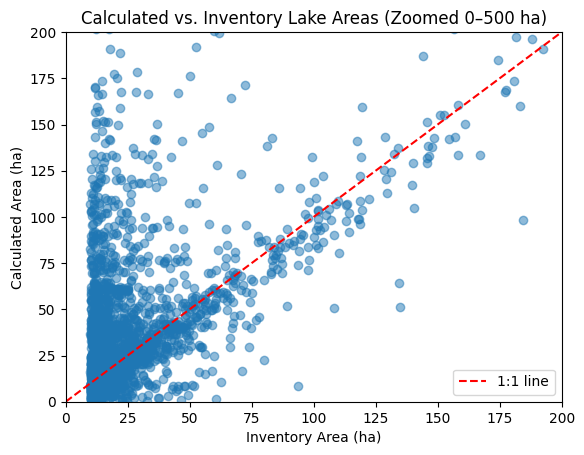

In [210]:
import matplotlib.pyplot as plt

plt.scatter(df_compare['Lake_area_ha'], df_compare['Lake_area_calculated_ha'], alpha=0.5)
plt.plot([0, 500], [0, 500], 'r--', label='1:1 line')

plt.xlim(0, 200)
plt.ylim(0, 200)

plt.xlabel("Inventory Area (ha)")
plt.ylabel("Calculated Area (ha)")
plt.legend()
plt.title("Calculated vs. Inventory Lake Areas (Zoomed 0–500 ha)")
plt.show()



Expansion Rate 5y

In [240]:
def calc_expansion_glof(feature):
    point = feature.geometry()
    year = ee.Number.parse(feature.get("Year_final")).toInt()
    years = ee.Number(5)

    # Detect lakes
    lake_t1 = detect_lake_pre_glof(point, year.subtract(5))
    lake_t2 = detect_lake_pre_glof(point, year)

    # Get raw areas
    area_t1_raw = lake_t1.get("Lake_area_calculated_ha")
    area_t2_raw = lake_t2.get("Lake_area_calculated_ha")

    # Absolute expansion (only if both areas exist)
    rate_abs = ee.Algorithms.If(
        ee.Algorithms.IsEqual(area_t1_raw, None),
        None,
        ee.Algorithms.If(
            ee.Algorithms.IsEqual(area_t2_raw, None),
            None,
            ee.Number(area_t2_raw).subtract(ee.Number(area_t1_raw)).divide(years)
        )
    )

    return (ee.Feature(lake_t2.geometry())
        .set("Latitude", feature.get("Latitude"))
        .set("Longitude", feature.get("Longitude"))
        .set("Year_final", year)
        .set("GLOF", feature.get("GLOF"))
        .set("area_t1", area_t1_raw)
        .set("area_t2", area_t2_raw)
        .set("expansion_ha_peryr", rate_abs))


In [241]:
def calc_expansion_nonglof(feature):
    point = feature.geometry()
    year = ee.Number.parse(feature.get("Year_final")).toInt()
    years = ee.Number(5)

    lake_t1 = detect_lake_from_point(point, year.subtract(5))
    lake_t2 = detect_lake_from_point(point, year)

    area_t1_raw = lake_t1.get("Lake_area_calculated_ha")
    area_t2_raw = lake_t2.get("Lake_area_calculated_ha")

    rate_abs = ee.Algorithms.If(
        ee.Algorithms.IsEqual(area_t1_raw, None),
        None,
        ee.Algorithms.If(
            ee.Algorithms.IsEqual(area_t2_raw, None),
            None,
            ee.Number(area_t2_raw).subtract(ee.Number(area_t1_raw)).divide(years)
        )
    )

    return (ee.Feature(lake_t2.geometry())
        .set("Latitude", feature.get("Latitude"))
        .set("Longitude", feature.get("Longitude"))
        .set("Year_final", year)
        .set("GLOF", feature.get("GLOF"))
        .set("area_t1", area_t1_raw)
        .set("area_t2", area_t2_raw)
        .set("expansion_ha_peryr", rate_abs))



In [242]:
fc_pos = df_to_fc(df_pos)

# --- Apply expansion calculation ---
fc_pos_expansion = fc_pos.map(calc_expansion_glof)

# --- Pull results back to pandas ---
result_pos = fc_pos_expansion.getInfo()["features"]

rows = []
for feat in result_pos:
    props = feat["properties"]
    rows.append(props)

df_pos_expansion = pd.DataFrame(rows)

In [248]:
df_pos_expansion.head()

,GLOF,Latitude,Longitude,Year_final,area_t2,area_t1,expansion_ha_peryr
0,1,42.522,74.609,1984,NaN,NaN,NaN
1,1,42.207,79.846,1984,NaN,NaN,NaN
2,1,35.677,77.193,1984,NaN,NaN,NaN
3,1,29.307,83.967,1985,NaN,NaN,NaN
4,1,36.039,74.633,1985,NaN,NaN,NaN


In [255]:
df_pos_expansion5y=df_pos_expansion
df_pos_expansion5y.head()
df_pos_expansion5y.to_csv("pos_expansion5y.csv")


In [ ]:
#adding neg_expansion5y

In [244]:
batch_size = 50
results = []

for i in range(0, len(df_neg_withcalculatedarea), batch_size):
    df_batch = df_neg_withcalculatedarea.iloc[i:i+batch_size]
    fc = df_to_fc(df_batch)

    # Apply expansion calculation
    fc_with_expansion = fc.map(calc_expansion_nonglof)

    # Pull properties back (including expansion)
    data = fc_with_expansion.getInfo()["features"]
    rows = [f["properties"] for f in data]
    results.append(pd.DataFrame(rows))

# Combine batches
df_expansion_updates = pd.concat(results, ignore_index=True)

# --- Merge with your original df (align by Latitude, Longitude, Year_final) ---
df_neg_expansion = pd.merge(
    df_neg_withcalculatedarea,
    df_expansion_updates[["Latitude", "Longitude", "Year_final",
                          "area_t1", "area_t2", "expansion_ha_peryr"]],
    on=["Latitude", "Longitude", "Year_final"],
    how="left"
)



In [249]:
df_neg_expansion.head()

,Lake_type,Longitude,Latitude,Year_final,Lake_area_ha,Elevation_m,GLOF,Lake_type_simplified,is_supraglacial,Lake_area_calculated_ha,area_t1,area_t2,expansion_ha_peryr
0,M(e),72.901,36.412,2019,11.23,4256,0,moraine,0,19.373351,124.050722,19.373351,-20.935474
1,O,73.048,36.263,2019,21.68,4618,0,other,0,18.463383,18.535790,18.463383,-0.014481
2,M(e),73.407,36.642,2019,14.06,2748,0,moraine,0,14.050228,11.960689,14.050228,0.417908
3,E(o),73.384,36.131,2019,23.35,4503,0,other,0,8.558558,9.138796,8.558558,-0.116048
4,E(o),73.423,36.116,2019,21.76,4437,0,other,0,11.896605,14.653179,11.896605,-0.551315


In [253]:
df_neg_expansion5y=df_neg_expansion
df_neg_expansion5y.head()


,Lake_type,Longitude,Latitude,Year_final,Lake_area_ha,Elevation_m,GLOF,Lake_type_simplified,is_supraglacial,Lake_area_calculated_ha,area_t1,area_t2,expansion_ha_peryr
0,M(e),72.901,36.412,2019,11.23,4256,0,moraine,0,19.373351,124.050722,19.373351,-20.935474
1,O,73.048,36.263,2019,21.68,4618,0,other,0,18.463383,18.535790,18.463383,-0.014481
2,M(e),73.407,36.642,2019,14.06,2748,0,moraine,0,14.050228,11.960689,14.050228,0.417908
3,E(o),73.384,36.131,2019,23.35,4503,0,other,0,8.558558,9.138796,8.558558,-0.116048
4,E(o),73.423,36.116,2019,21.76,4437,0,other,0,11.896605,14.653179,11.896605,-0.551315


In [254]:
df_neg_expansion5y.to_csv("neg_expansion5y.csv")

######## 10Y expansion rate#########

In [12]:
def calc_expansion_glof(feature):
    point = feature.geometry()
    year = ee.Number.parse(feature.get("Year_final")).toInt()
    years = ee.Number(5)

    # Detect lakes
    lake_t1 = detect_lake_pre_glof(point, year.subtract(10))
    lake_t2 = detect_lake_pre_glof(point, year)

    # Get raw areas
    area_t1_raw = lake_t1.get("Lake_area_calculated_ha")
    area_t2_raw = lake_t2.get("Lake_area_calculated_ha")

    # Absolute expansion (only if both areas exist)
    rate_abs = ee.Algorithms.If(
        ee.Algorithms.IsEqual(area_t1_raw, None),
        None,
        ee.Algorithms.If(
            ee.Algorithms.IsEqual(area_t2_raw, None),
            None,
            ee.Number(area_t2_raw).subtract(ee.Number(area_t1_raw)).divide(years)
        )
    )

    return (ee.Feature(lake_t2.geometry())
        .set("Latitude", feature.get("Latitude"))
        .set("Longitude", feature.get("Longitude"))
        .set("Year_final", year)
        .set("GLOF", feature.get("GLOF"))
        .set("area_t1", area_t1_raw)
        .set("area_t2", area_t2_raw)
        .set("expansion_ha_peryr", rate_abs))
    
def calc_expansion_nonglof(feature):
    point = feature.geometry()
    year = ee.Number.parse(feature.get("Year_final")).toInt()
    years = ee.Number(5)

    lake_t1 = detect_lake_from_point(point, year.subtract(10))
    lake_t2 = detect_lake_from_point(point, year)

    area_t1_raw = lake_t1.get("Lake_area_calculated_ha")
    area_t2_raw = lake_t2.get("Lake_area_calculated_ha")

    rate_abs = ee.Algorithms.If(
        ee.Algorithms.IsEqual(area_t1_raw, None),
        None,
        ee.Algorithms.If(
            ee.Algorithms.IsEqual(area_t2_raw, None),
            None,
            ee.Number(area_t2_raw).subtract(ee.Number(area_t1_raw)).divide(years)
        )
    )

    return (ee.Feature(lake_t2.geometry())
        .set("Latitude", feature.get("Latitude"))
        .set("Longitude", feature.get("Longitude"))
        .set("Year_final", year)
        .set("GLOF", feature.get("GLOF"))
        .set("area_t1", area_t1_raw)
        .set("area_t2", area_t2_raw)
        .set("expansion_ha_peryr", rate_abs))



In [13]:
import pandas as pd
df_neg_expansion5y=pd.read_csv("neg_expansion5y.csv")

In [ ]:
batch_size = 50
results = []

for i in range(0, len(df_neg_expansion5y), batch_size):
    df_batch = df_neg_expansion5y.iloc[i:i+batch_size]
    fc = df_to_fc(df_batch)

    # Apply expansion calculation
    fc_with_expansion10y = fc.map(calc_expansion_nonglof)

    # Pull properties back (including expansion)
    data = fc_with_expansion10y.getInfo()["features"]
    rows = [f["properties"] for f in data]
    results.append(pd.DataFrame(rows))

# Combine batches
df_expansion_updates = pd.concat(results, ignore_index=True)




In [21]:
df_neg_withcalculatedarea=pd.read_csv("df_neg_withcalculatedarea.csv")
df_neg_withcalculatedarea.head()

,Unnamed: 0,Lake_type,Longitude,Latitude,Year_final,Lake_area_ha,Elevation_m,GLOF,Lake_type_simplified,is_supraglacial,Lake_area_calculated_ha
0,0,M(e),72.901,36.412,2019,11.23,4256,0,moraine,0,19.373351
1,1,O,73.048,36.263,2019,21.68,4618,0,other,0,18.463383
2,2,M(e),73.407,36.642,2019,14.06,2748,0,moraine,0,14.050228
3,3,E(o),73.384,36.131,2019,23.35,4503,0,other,0,8.558558
4,4,E(o),73.423,36.116,2019,21.76,4437,0,other,0,11.896605


In [22]:
# --- Merge with your original df (align by Latitude, Longitude, Year_final) ---
df_neg_expansion10y = pd.merge(
    df_neg_withcalculatedarea,
    df_expansion_updates[["Latitude", "Longitude", "Year_final",
                          "area_t1", "area_t2", "expansion_ha_peryr"]],
    on=["Latitude", "Longitude", "Year_final"],
    how="left"
)


In [24]:
df_neg_expansion10y.to_csv("neg_expansion10y.csv")

#positive expansion 10y

In [26]:
df_pos_calculatedarea=pd.read_csv("df_pos_calculatedarea.csv")
df_pos_calculatedarea.head()

,Unnamed: 0,Elevation_m,GLOF,Lake_type,Lake_type_simplified,Latitude,Longitude,Year_final,id,is_supraglacial,Lake_area_calculated_ha,Lake_area_ha
0,0,3466,1,water pocket,other,42.522,74.609,1984,0,0,NaN,NaN
1,1,3269,1,ice,ice,42.207,79.846,1984,1,0,NaN,NaN
2,2,4779,1,ice,ice,35.677,77.193,1984,2,0,NaN,NaN
3,3,4594,1,water pocket,other,29.307,83.967,1985,3,0,NaN,NaN
4,4,3301,1,water pocket,other,36.039,74.633,1985,4,0,NaN,NaN


In [30]:
fc_pos_calculatedarea = df_to_fc(df_pos_calculatedarea)

# --- Apply expansion calculation ---
fc_pos_expansion10y = fc_pos_calculatedarea.map(calc_expansion_glof)

# --- Pull results back to pandas ---
result_pos= fc_pos_expansion10y.getInfo()["features"]

rows = []
for feat in result_pos:
    props = feat["properties"]
    rows.append(props)

df_pos_expansion10y = pd.DataFrame(rows)

In [33]:
df_pos_expansion10y.head()

,GLOF,Latitude,Longitude,Year_final,area_t2,area_t1,expansion_ha_peryr
0,1,42.522,74.609,1984,NaN,NaN,NaN
1,1,42.207,79.846,1984,NaN,NaN,NaN
2,1,35.677,77.193,1984,NaN,NaN,NaN
3,1,29.307,83.967,1985,NaN,NaN,NaN
4,1,36.039,74.633,1985,NaN,NaN,NaN


In [32]:
df_pos_expansion10y.to_csv("pos_expansion10y.csv")

In [22]:
#gets the nearest glacier polygons to lake "polygon" and if not touch just gets the closest glacier's info: not fully server side

In [117]:
def get_nearest_glacier(lake_geom, buffer_km=50):
    """
    Given a lake polygon, finds nearest or touching glacier(s).
    Returns consistent features for ML:
      - glacier_contact (bool)
      - nearest_glacier_dist_m
      - lake_elev_m
      - glacier_elev_m (from chosen glacier)
      - slope_glac_to_lake (rise/run, slope=0 if touching)
      - glacier_area_km2 (sum of all touching glaciers, or area of nearest one)
      - glacier_ids (list of GLIMS IDs for touching glaciers, or [nearest_id])
    """
    glaciers = ee.FeatureCollection("GLIMS/current")
    dem = ee.Image("USGS/SRTMGL1_003")

    # Filter glaciers within buffer
    nearby = glaciers.filterBounds(lake_geom.buffer(buffer_km * 1000))

    # Glaciers that touch/intersect the lake
    touching = nearby.filterBounds(lake_geom)

    # --- Case 1: touching glaciers ---
    if touching.size().getInfo() > 0:
        # Add area for each
        def add_area(f):
            return f.set("glacier_area_km2", f.geometry().area(maxError=30).divide(1e6))
        touching = touching.map(add_area)

        # Glacier with largest area (used for slope reference)
        largest_touching = ee.Feature(touching.sort("glacier_area_km2", False).first())

        # Collect all glacier IDs
        glacier_ids = touching.aggregate_array("glac_id").getInfo()

        # Metrics
        combined_area = touching.aggregate_sum("glacier_area_km2").getInfo()
        lake_elev = dem.sample(lake_geom.centroid(maxError=30), 30).first().get("elevation").getInfo()
        glac_elev = dem.sample(largest_touching.geometry().centroid(maxError=30), 30).first().get("elevation").getInfo()

        return {
            "glacier_contact": True,
            "nearest_glacier_dist_m": 0,   # touching → distance = 0
            "lake_elev_m": lake_elev,
            "glacier_elev_m": glac_elev,
            "slope_glac_to_lake": 0,      # standardized → slope=0 when touching
            "glacier_area_km2": combined_area,   # sum of all touching glaciers
            "glacier_ids": glacier_ids    # all touching glaciers
        }

    # --- Case 2: no touching glaciers ---
    else:
        # Compute distances
        with_dist = nearby.map(lambda g: g.set("dist", g.geometry().distance(lake_geom, maxError=30)))
        nearest = ee.Feature(with_dist.sort("dist").first())

        # Metrics
        distance = nearest.get("dist").getInfo()
        area_km2 = nearest.geometry().area(maxError=30).divide(1e6).getInfo()
        lake_elev = dem.sample(lake_geom.centroid(maxError=30), 30).first().get("elevation").getInfo()
        glac_elev = dem.sample(nearest.geometry().centroid(maxError=30), 30).first().get("elevation").getInfo()

        slope = (glac_elev - lake_elev) / distance if (lake_elev and glac_elev and distance > 0) else None

        return {
            "glacier_contact": False,
            "nearest_glacier_dist_m": distance,
            "lake_elev_m": lake_elev,
            "glacier_elev_m": glac_elev,
            "slope_glac_to_lake": slope,
            "glacier_area_km2": area_km2,
            "glacier_ids": [nearest.get("glac_id").getInfo()]  # single nearest glacier
        }




In [24]:
#visualize glacier features:

In [129]:
def visualize_glacierE(lake_geom, glacier_info, zoom=11):
    """
    Visualize the lake polygon, glaciers (touching or nearest), and connection line.
    Compatible with the new get_nearest_glacier() output.
    """
    # Base map
    center = lake_geom.centroid(maxError=30).coordinates().getInfo()[::-1]  # [lat, lon]
    m = geemap.Map(center=center, zoom=zoom)
    m.add_basemap("SATELLITE")

    # DEM overlay (SRTM 30m)
    dem = ee.Image("USGS/SRTMGL1_003")
    dem_vis = {
        "min": 4000,
        "max": 6000,
        "palette": ["blue", "green", "yellow", "orange", "red", "white"]
    }
    m.addLayer(dem, dem_vis, "DEM Elevation")

    # Lake polygon
    m.addLayer(lake_geom, {"color": "cyan"}, "Lake Polygon")

    if glacier_info["glacier_contact"]:a
        # --- Case 1: Touching glaciers ---
        largest_overlap = ee.Feature(glacier_info["largest_overlap_glacier"])
        m.addLayer(largest_overlap.geometry(), {"color": "purple"}, "Largest Overlap Glacier")

    else:
        # --- Case 2: Nearest glacier ---
        nearest = ee.Feature(glacier_info["nearest_glacier"])
        nearest_point = nearest.geometry().centroid(maxError=30)
        lake_centroid = lake_geom.centroid(maxError=30)

        # Buffers
        m.addLayer(lake_centroid.buffer(200), {"color": "black"}, "Lake Centroid")
        m.addLayer(nearest_point.buffer(100), {"color": "red"}, "Nearest Glacier Point")

        # Glacier polygon
        m.addLayer(nearest.geometry(), {"color": "purple"}, "Nearest Glacier")

        # Connection line
        line = ee.Geometry.LineString([
            lake_centroid.coordinates(),
            nearest_point.coordinates()
        ])
        m.addLayer(line, {"color": "yellow", "width": 2}, "Connection Line")

    return m




IndentationError: unexpected indent (2632603893.py, line 25)

In [119]:
# --- Test one lake ---
lat, lon = 27.864,87.837   # example coords
point = ee.Geometry.Point([lon, lat])

# 1. Detect lake polygon
lake_result = detect_lake_from_point(point, 2016)
lake_fc = ee.FeatureCollection(lake_result["lake_fc"])
print("Lake polygons detected:", lake_fc.size().getInfo())

if lake_fc.size().getInfo() > 0:
    lake_geom = ee.Feature(lake_fc.first()).geometry(maxError=30)
    print("Lake area (km²):", lake_geom.area(maxError=30).divide(1e6).getInfo())

    # 2. Run glacier analysis
    glacier_info = get_nearest_glacier(lake_geom, buffer_km=50)


else:
    print("No lake detected for this point/year.")


TypeError: 'Feature' object is not subscriptable

In [123]:
lat,lon=36.145,73.639
point = ee.Geometry.Point([lon, lat])   # Earth Engine Point, order = [lon, lat]

lake_result = detect_lake_from_point(point, 2016)


# This is a FeatureCollection

lake_fc = ee.FeatureCollection(lake_result["lake_fc"])
lake_geom = ee.Feature(lake_fc.first()).geometry()

m = visualize_glacierE(lake_geom, glacier_info, zoom=11)
m


TypeError: 'Feature' object is not subscriptable

#for individual longitude latitude (not fully server side)

In [120]:
import ee, geemap

# --- Glacier analysis function ---
def get_nearest_glacier(lake_geom, buffer_km=50):
    """
    Given a lake polygon, finds nearest or touching glacier(s).
    Returns features for ML and visualization:
      - glacier_contact (bool)
      - nearest_glacier_dist_m
      - lake_elev_m
      - glacier_elev_m (from chosen glacier)
      - slope_glac_to_lake (rise/run, slope=0 if touching)
      - glacier_area_km2 (sum of all touching glaciers, or area of nearest one)
      - glacier_ids (list of GLIMS IDs for touching glaciers, or [nearest_id])
      - largest_overlap_glacier (ee.Feature, only if contact=True)
      - nearest_glacier (ee.Feature, only if contact=False)
    """
    glaciers = ee.FeatureCollection("GLIMS/current")
    dem = ee.Image("USGS/SRTMGL1_003")

    # Filter glaciers within buffer
    nearby = glaciers.filterBounds(lake_geom.buffer(buffer_km * 1000))

    # Glaciers that touch/intersect the lake
    touching = nearby.filterBounds(lake_geom)

    # --- Case 1: touching glaciers ---
    if touching.size().getInfo() > 0:
        # Add area for each
        def add_area(f):
            return f.set("glacier_area_km2", f.geometry().area(maxError=30).divide(1e6))
        touching = touching.map(add_area)

        # Glacier with largest area
        largest_touching = ee.Feature(touching.sort("glacier_area_km2", False).first())

        # Collect all glacier IDs
        glacier_ids = touching.aggregate_array("glac_id").getInfo()

        # Metrics
        combined_area = touching.aggregate_sum("glacier_area_km2").getInfo()
        lake_elev = dem.sample(lake_geom.centroid(maxError=30), 30).first().get("elevation").getInfo()
        glac_elev = dem.sample(largest_touching.geometry().centroid(maxError=30), 30).first().get("elevation").getInfo()

        return {
            "glacier_contact": True,
            "nearest_glacier_dist_m": 0,
            "lake_elev_m": lake_elev,
            "glacier_elev_m": glac_elev,
            "slope_glac_to_lake": 0,
            "glacier_area_km2": combined_area,
            "glacier_ids": glacier_ids,
            "largest_overlap_glacier": largest_touching,
            "nearest_glacier": None
        }

    # --- Case 2: no touching glaciers ---
    else:
        # Compute distances
        with_dist = nearby.map(lambda g: g.set("dist", g.geometry().distance(lake_geom, maxError=30)))
        nearest = ee.Feature(with_dist.sort("dist").first())

        # Metrics
        distance = nearest.get("dist").getInfo()
        area_km2 = nearest.geometry().area(maxError=30).divide(1e6).getInfo()
        lake_elev = dem.sample(lake_geom.centroid(maxError=30), 30).first().get("elevation").getInfo()
        glac_elev = dem.sample(nearest.geometry().centroid(maxError=30), 30).first().get("elevation").getInfo()

        slope = (glac_elev - lake_elev) / distance if (lake_elev and glac_elev and distance > 0) else None

        return {
            "glacier_contact": False,
            "nearest_glacier_dist_m": distance,
            "lake_elev_m": lake_elev,
            "glacier_elev_m": glac_elev,
            "slope_glac_to_lake": slope,
            "glacier_area_km2": area_km2,
            "glacier_ids": [nearest.get("glac_id").getInfo()],
            "largest_overlap_glacier": None,
            "nearest_glacier": nearest
        }


# --- Visualization function (works with the above output) ---
def visualize_glacierE(lake_geom, glacier_info, zoom=11):
    """
    Visualize the lake polygon, glaciers (touching or nearest), and connection line.
    Compatible with the new get_nearest_glacier() output.
    """
    # Base map
    center = lake_geom.centroid(maxError=30).coordinates().getInfo()[::-1]  # [lat, lon]
    m = geemap.Map(center=center, zoom=zoom)
    m.add_basemap("SATELLITE")

    # DEM overlay
    dem = ee.Image("USGS/SRTMGL1_003")
    dem_vis = {"min": 4000, "max": 6000, "palette": ["blue", "green", "yellow", "orange", "red", "white"]}
    m.addLayer(dem, dem_vis, "DEM Elevation")

    # Lake polygon
    m.addLayer(lake_geom, {"color": "cyan"}, "Lake Polygon")

    if glacier_info["glacier_contact"]:
        # --- Case 1: Touching glaciers ---
        largest_overlap = ee.Feature(glacier_info["largest_overlap_glacier"])
        m.addLayer(largest_overlap.geometry(), {"color": "purple"}, "Largest Overlap Glacier")

    else:
        # --- Case 2: Nearest glacier ---
        nearest = ee.Feature(glacier_info["nearest_glacier"])
        nearest_point = nearest.geometry().centroid(maxError=30)
        lake_centroid = lake_geom.centroid(maxError=30)

        m.addLayer(lake_centroid.buffer(200), {"color": "black"}, "Lake Centroid")
        m.addLayer(nearest_point.buffer(100), {"color": "red"}, "Nearest Glacier Point")
        m.addLayer(nearest.geometry(), {"color": "purple"}, "Nearest Glacier")

        line = ee.Geometry.LineString([
            lake_centroid.coordinates(),
            nearest_point.coordinates()
        ])
        m.addLayer(line, {"color": "yellow", "width": 2}, "Connection Line")
        # ✅ Add scale bar (km reference as you zoom)
        m.add_child(geemap.ScaleBar(position="bottomleft"))

    return m


In [121]:
lat, lon = 28.283,86.502
point = ee.Geometry.Point([lon, lat])

lake_result = detect_lake_from_point(point, 2016)
lake_fc = ee.FeatureCollection(lake_result["lake_fc"])

lake_geom = ee.Feature(lake_fc.first()).geometry()
glacier_info = get_nearest_glacier(lake_geom, buffer_km=50)
m = visualize_glacierE(lake_geom, glacier_info)
m  # display map


TypeError: 'Feature' object is not subscriptable

In [130]:
lat, lon = 35.016,75.001
point = ee.Geometry.Point([lon, lat])

lake_result = detect_lake_from_point(point, 2016)
lake_fc = ee.FeatureCollection(lake_result["lake_fc"])

lake_geom = ee.Feature(lake_fc.first()).geometry()
glacier_info = get_nearest_glacier(lake_geom, buffer_km=50)
m = visualize_glacierE(lake_geom, glacier_info)
m  # display map




AttributeError: 'Map' object has no attribute 'add_child'

In [ ]:
#####final glacier features calculation: all server side for minimum running time when applying on dataframes

In [52]:
import ee, pandas as pd

# --- 1) Core: annotate ONE lake polygon with glacier metrics (all server-side) ---
def _glacier_metrics_for_lake_polygon(lake, buffer_km=50):
    glaciers = ee.FeatureCollection("GLIMS/current")
    dem      = ee.Image("USGS/SRTMGL1_003")

    # Ensure non-zero-area geometry (handles accidental points)
    lake_geom = ee.Feature(lake).geometry().buffer(1)

    # Candidate glaciers within search buffer (meters)
    search = lake_geom.buffer(ee.Number(buffer_km).multiply(1000))
    nearby = glaciers.filterBounds(search)

    # If no glaciers nearby → return null-like fields
    def _no_hits(f):
        return ee.Feature(f).set({
            "glacier_contact": False,
            "glacier_touch_count": 0,
            "nearest_glacier_dist_m": None,
            "lake_elev_m": None,
            "glacier_elev_m": None,
            "slope_glac_to_lake": None,
            "glacier_area_ha": None,
            "glacier_ids": ee.List([]),
            "buffer_km_used": buffer_km,
            "slope_method": "min_segment_poly_to_poly"
        })

    # If glaciers found → compute metrics
    def _compute(f):
        # Per-glacier metrics: distance and area (in hectares)
        def add_metrics(g):
            gg = ee.Feature(g).geometry()
            return ee.Feature(g).set({
                "dist": gg.distance(lake_geom, 1),            # meters (0 if overlap/touch)
                "glacier_area_ha": gg.area(1).divide(1e4)     # hectares
            })
        with_metrics = nearby.map(add_metrics)

        # Nearest glacier by poly↔poly min distance
        nearest  = ee.Feature(with_metrics.sort("dist").first())
        min_dist = ee.Number(nearest.get("dist"))
ke
        # Touching glaciers (dist == 0)
        touching       = with_metrics.filter(ee.Filter.eq("dist", 0))
        touch_ids_list = ee.List(touching.aggregate_array("glac_id")).distinct()
        touch_count    = touch_ids_list.length()

        # Total area if multiple touching glaciers
        touch_area = ee.Algorithms.If(
            touch_count.gt(0),
            ee.Number(touching.aggregate_sum("glacier_area_ha")),
            ee.Number(0)
        )

        # Closest points for elevation sampling
        nearest_geom = nearest.geometry()
        lake_near_pt = lake_geom.closestPoint(nearest_geom, 1)
        glac_near_pt = nearest_geom.closestPoint(lake_geom, 1)

        lake_elev = dem.sample(lake_near_pt, 30).first().get("elevation")
        glac_elev = dem.sample(glac_near_pt, 30).first().get("elevation")

        # Slope along the min-distance line; 0 if touching/overlap
        slope = ee.Algorithms.If(
            min_dist.gt(0),
            ee.Number(glac_elev).subtract(ee.Number(lake_elev)).divide(min_dist),
            ee.Number(0)
        )

        # Use summed area/IDs if touching; else nearest glacier’s stats
        area_choice = ee.Algorithms.If(touch_count.gt(0), touch_area, nearest.get("glacier_area_ha"))
        ids_choice  = ee.Algorithms.If(touch_count.gt(0), touch_ids_list, ee.List([nearest.get("glac_id")]))

        return ee.Feature(f).set({
            "glacier_contact":        touch_count.gt(0),
            "glacier_touch_count":    touch_count,
            "nearest_glacier_dist_m": min_dist,         # 0 if touching/overlap
            "lake_elev_m":            lake_elev,        # at closest point on lake polygon
            "glacier_elev_m":         glac_elev,        # at closest point on glacier polygon
            "slope_glac_to_lake":     slope,            # 0 if touching/overlap
            "glacier_area_ha":        area_choice,      # hectares (sum if multiple touching)
            "glacier_ids":            ids_choice,
            "buffer_km_used":         buffer_km,
            "slope_method":           "min_segment_poly_to_poly"
        })

    return ee.Feature(
        ee.Algorithms.If(nearby.size().eq(0), _no_hits(lake), _compute(lake))
    )
# --- 2) Public: map over a FeatureCollection whose geometry is a LAKE POLYGON (or point) ---
def annotate_glacier_metrics_from_polygons(lakes_fc, buffer_km=50):
    """
    Input:  FeatureCollection where geometry is the LAKE polygon.
            (If some are points, they are buffered 1 m internally so distance works.)
    Output: Same features with glacier metrics added as properties (server-side).
    """
    return ee.FeatureCollection(
        ee.FeatureCollection(lakes_fc).map(
            lambda f: _glacier_metrics_for_lake_polygon(ee.Feature(f), buffer_km)
        )
    )


In [ ]:
# Step 1: DataFrame -> FC of points
points_fc = df_to_fc(df)

# Step 2: Map lake-detection wrapper to get polygons
def detect_area_glof(feature):
    point = feature.geometry()
    year  = ee.Number.parse(feature.get("Year_final")).toInt()
    lake  = detect_lake_pre_glof(point, year)
    # keep all properties and explicitly carry the area
    return ee.Feature(lake).copyProperties(feature).set(
        'Lake_area_calculated_ha', lake.get('Lake_area_calculated_ha')
    )

lakes_fc = points_fc.map(detect_area_glof)



In [65]:
df_pos_expansion10y=pd.read_csv("pos_expansion10y.csv")

In [35]:
df_pos_expansion10y.head()

,Unnamed: 0,GLOF,Latitude,Longitude,Year_final,area_t2,area_t1,expansion_ha_peryr
0,0,1,42.522,74.609,1984,NaN,NaN,NaN
1,1,1,42.207,79.846,1984,NaN,NaN,NaN
2,2,1,35.677,77.193,1984,NaN,NaN,NaN
3,3,1,29.307,83.967,1985,NaN,NaN,NaN
4,4,1,36.039,74.633,1985,NaN,NaN,NaN


In [90]:
df_pos_expansion10y5row=df_pos_expansion10y[:20]
df_pos_expansion10y5row


,Unnamed: 0,GLOF,Latitude,Longitude,Year_final,area_t2,area_t1,expansion_ha_peryr
0,0,1,42.522,74.609,1984,NaN,NaN,NaN
1,1,1,42.207,79.846,1984,NaN,NaN,NaN
2,2,1,35.677,77.193,1984,NaN,NaN,NaN
3,3,1,29.307,83.967,1985,NaN,NaN,NaN
4,4,1,36.039,74.633,1985,NaN,NaN,NaN
5,5,1,41.975,76.867,1985,NaN,NaN,NaN
6,6,1,27.874,86.586,1985,NaN,NaN,NaN
7,7,1,42.207,79.846,1985,NaN,NaN,NaN
8,8,1,36.414,74.879,1986,NaN,NaN,NaN
9,9,1,27.586,88.027,1986,NaN,NaN,NaN


In [39]:
def fc_properties_to_df(fc, max_items=5000):
    fc_limited = ee.FeatureCollection(fc).limit(max_items)
    feats = fc_limited.getInfo()["features"]
    rows = [f["properties"] for f in feats]
    return pd.DataFrame(rows)


#testing on some rows

In [133]:

# DataFrame -> FC of points (has 'id' uniqued in df_to_fc)
import numpy as np
import pandas as pd

df_safe = df_pos_expansion10y5row.copy()
# Replace NaN and +/-inf with None (EE → null)
df_safe = df_safe.replace([np.nan, np.inf, -np.inf], None)

fc_points = df_to_fc(df_safe)

# Map your lake-detection wrapper to get polygons with area property
fc_polys = fc_points.map(detect_area_glof)

# buffer_km can be tuned; 50 km is your default
fc_polys_with_glac = annotate_glacier_metrics_from_polygons(fc_polys, buffer_km=5)
df_glac_props = fc_properties_to_df(fc_polys_with_glac, max_items=len(df_pos_expansion10y5row))

# Keep only the columns you care about
df_glac_trial = df_glac_props[[
    "glacier_area_ha",             # glacier area in hectares
    "slope_glac_to_lake",          # slope from glacier to lake
    "glacier_contact",             # True/False if touching
    "glacier_touch_count",         # number of glaciers directly touching
    "nearest_glacier_dist_m",      # distance to nearest glacier (m)
    "glacier_elev_m",               # glacier elevation (m)
    "Latitude",
    "Longitude",
    "Year_final"

]]
df_glac_trial.head()

,glacier_area_ha,slope_glac_to_lake,glacier_contact,glacier_touch_count,nearest_glacier_dist_m,glacier_elev_m,Latitude,Longitude,Year_final
0,100.235218,-0.222707,False,0,835.177083,3466.0,42.522,74.609,1984
1,396.118156,-0.098587,False,0,446.305779,3269.0,42.207,79.846,1984
2,9444.515664,-0.003858,False,0,1036.810675,4779.0,35.677,77.193,1984
3,NaN,NaN,False,0,NaN,NaN,29.307,83.967,1985
4,3042.883735,0.313233,False,0,181.973111,3301.0,36.039,74.633,1985


#applying for glof list:

In [92]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

batch_size = 10
results = []

n_batches = (len(df_pos_expansion10y) + batch_size - 1) // batch_size

for i in tqdm(range(0, len(df_pos_expansion10y), batch_size), 
              total=n_batches, desc="Processing glacier batches"):
    df_batch = df_pos_expansion10y.iloc[i:i+batch_size].copy()
    df_batch = df_batch.replace([np.nan, np.inf, -np.inf], None)

    fc_points = df_to_fc(df_batch)
    fc_polys = fc_points.map(detect_area_glof)
    fc_with_glac = annotate_glacier_metrics_from_polygons(fc_polys, buffer_km=5)

    # Remove geometries to lighten payload
    fc_with_glac = fc_with_glac.map(lambda f: f.setGeometry(None))

    data = fc_with_glac.getInfo()["features"]
    rows = [f["properties"] for f in data]
    results.append(pd.DataFrame(rows))

df_glac_updates = pd.concat(results, ignore_index=True)

df_glac_pos = pd.merge(
    df_pos_expansion10y,
    df_glac_updates[[
        "Latitude", "Longitude", "Year_final",
        "glacier_area_ha", "slope_glac_to_lake",
        "glacier_contact", "glacier_touch_count",
        "nearest_glacier_dist_m", "glacier_elev_m"
    ]],
    on=["Latitude", "Longitude", "Year_final"],
    how="left"
)

print("✅ Glacier features merged. Final dataframe shape:", df_glac_pos.shape)



Processing glacier batches:   0%|          | 0/25 [00:00<?, ?it/s]

✅ Glacier features merged. Final dataframe shape: (269, 14)


In [105]:
df_glac_pos[:20]

,Unnamed: 0,GLOF,Latitude,Longitude,Year_final,area_t2,area_t1,expansion_ha_peryr,glacier_area_ha,slope_glac_to_lake,glacier_contact,glacier_touch_count,nearest_glacier_dist_m,glacier_elev_m
0,0,1,42.522,74.609,1984,NaN,NaN,NaN,536.125805,0.000000,1,1,0.000000,3466.0
1,1,1,42.207,79.846,1984,NaN,NaN,NaN,396.118156,-0.098587,0,0,446.305779,3269.0
2,2,1,35.677,77.193,1984,NaN,NaN,NaN,9444.515664,-0.003858,0,0,1036.810675,4779.0
3,3,1,29.307,83.967,1985,NaN,NaN,NaN,NaN,NaN,False,0,NaN,NaN
4,4,1,36.039,74.633,1985,NaN,NaN,NaN,6998.712273,0.000000,1,2,0.000000,3301.0
5,5,1,41.975,76.867,1985,NaN,NaN,NaN,38.457305,-0.144369,0,0,768.862677,3632.0
6,6,1,27.874,86.586,1985,NaN,NaN,NaN,652.480729,0.000000,1,2,0.000000,4368.0
7,7,1,42.207,79.846,1985,NaN,NaN,NaN,396.118156,-0.098587,0,0,446.305779,3269.0
8,8,1,36.414,74.879,1986,NaN,NaN,NaN,2339.676629,-0.312231,0,0,198.570765,2501.0
9,9,1,27.586,88.027,1986,NaN,NaN,NaN,29403.154647,0.000000,1,1,0.000000,4437.0


In [95]:
df_glac_pos.to_csv("glac_pos_list.csv")

#Applying glacier features for negatives non glofs

In [ ]:
def detect_area_nonglof(feature):
    point = feature.geometry()
    year  = ee.Number.parse(feature.get("Year_final")).toInt()
    lake  = detect_lake_from_point(point, year)

    # Return the lake feature, with all original properties copied,
    # and explicitly keep the calculated area
    return ee.Feature(lake).copyProperties(feature).set(
        'Lake_area_calculated_ha', lake.get('Lake_area_calculated_ha')
    )


In [101]:
df_neg_expansion10y5row = pd.read_csv("neg_expansion10y.csv", nrows=5)
df_neg_expansion10y5row = df_neg_expansion10y5row.loc[:, ~df_neg_expansion10y5row.columns.str.contains("^Unnamed")]
df_neg_expansion10y5row

,Lake_type,Longitude,Latitude,Year_final,Lake_area_ha,Elevation_m,GLOF,Lake_type_simplified,is_supraglacial,Lake_area_calculated_ha,area_t1,area_t2,expansion_ha_peryr
0,M(e),72.901,36.412,2019,11.23,4256,0,moraine,0,19.373351,14.746084,19.373351,0.925453
1,O,73.048,36.263,2019,21.68,4618,0,other,0,18.463383,29.256848,18.463383,-2.158693
2,M(e),73.407,36.642,2019,14.06,2748,0,moraine,0,14.050228,36.037797,14.050228,-4.397514
3,E(o),73.384,36.131,2019,23.35,4503,0,other,0,8.558558,7.979208,8.558558,0.115870
4,E(o),73.423,36.116,2019,21.76,4437,0,other,0,11.896605,18.498023,11.896605,-1.320284


In [102]:
import numpy as np
import pandas as pd

df_safe = df_neg_expansion10y5row.copy()
# Replace NaN and +/-inf with None (EE → null)
df_safe = df_safe.replace([np.nan, np.inf, -np.inf], None)

fc_points = df_to_fc(df_safe)

# Map your lake-detection wrapper to get polygons with area property
fc_polys = fc_points.map(detect_area_nonglof)

# buffer_km can be tuned; 5 km here for faster run
fc_polys_with_glac = annotate_glacier_metrics_from_polygons(fc_polys, buffer_km=5)

df_glac_props = fc_properties_to_df(fc_polys_with_glac, 
                                    max_items=len(df_neg_expansion10y5row))

# Keep only the columns you care about
df_glac_trial_neg = df_glac_props[[
    "glacier_area_ha",             # glacier area in hectares
    "slope_glac_to_lake",          # slope from glacier to lake
    "glacier_contact",             # True/False if touching
    "glacier_touch_count",         # number of glaciers directly touching
    "nearest_glacier_dist_m",      # distance to nearest glacier (m)
    "glacier_elev_m",              # glacier elevation (m)
    "Latitude",
    "Longitude",
    "Year_final",
    "Lake_area_calculated_ha",
    "Lake_type_simplified",
    "Lake_area_ha",
    "expansion_ha_peryr"
]]

# Show first rows
df_glac_trial_neg.head()


,glacier_area_ha,slope_glac_to_lake,glacier_contact,glacier_touch_count,nearest_glacier_dist_m,glacier_elev_m,Latitude,Longitude,Year_final,Lake_area_calculated_ha,Lake_type_simplified,Lake_area_ha,expansion_ha_peryr
0,735.527880,0.000000,1,2,0.000000,4817,36.412,72.901,2019,19.373351,moraine,11.23,0.925453
1,12.913846,-0.488618,0,0,726.539168,4619,36.263,73.048,2019,18.463383,other,21.68,-2.158693
2,4204.096644,0.000000,1,1,0.000000,2767,36.642,73.407,2019,14.050228,moraine,14.06,-4.397514
3,12.377344,-0.205894,0,0,607.107220,4513,36.131,73.384,2019,8.558558,other,23.35,0.115870
4,31.006463,-0.315604,0,0,703.413916,4447,36.116,73.423,2019,11.896605,other,21.76,-1.320284


In [109]:
df_neg_expansion10y = pd.read_csv("neg_expansion10y.csv")
df_neg_expansion10y = df_neg_expansion10y.loc[:, ~df_neg_expansion10y.columns.str.contains("^Unnamed")]
df_neg_expansion10y[100:120]

,Lake_type,Longitude,Latitude,Year_final,Lake_area_ha,Elevation_m,GLOF,Lake_type_simplified,is_supraglacial,Lake_area_calculated_ha,area_t1,area_t2,expansion_ha_peryr
100,E(c),74.828,34.537,2019,30.51,3922,0,other,0,26.408398,1.553212,26.408398,4.971037
101,E(o),74.921,34.493,2019,38.39,3881,0,other,0,34.045510,19.169000,34.045510,2.975302
102,E(c),74.906,34.489,2019,11.89,4097,0,other,0,34.045510,19.169000,34.045510,2.975302
103,E(o),74.913,34.470,2019,10.44,3852,0,other,0,33.749496,19.169000,33.749496,2.916099
104,M(o),74.985,34.457,2019,10.33,3748,0,moraine,0,6.589909,3.110005,6.589909,0.695981
105,E(o),74.932,34.452,2019,12.30,3889,0,other,0,150.427946,145.539543,150.427946,0.977681
106,E(c),74.909,34.448,2019,15.48,3979,0,other,0,129.688813,126.652147,129.688813,0.607333
107,E(c),74.892,34.444,2019,33.95,3846,0,other,0,60.362914,58.733523,60.362914,0.325878
108,E(c),74.924,34.432,2019,161.04,3571,0,other,0,150.427946,145.539543,150.427946,0.977681
109,E(o),74.936,34.418,2019,36.65,3503,0,other,0,150.427946,145.539543,150.427946,0.977681


In [110]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

batch_size = 15
results = []

n_batches = (len(df_neg_expansion10y) + batch_size - 1) // batch_size

for i in tqdm(range(0, len(df_neg_expansion10y), batch_size), 
              total=n_batches, desc="Processing negative glacier batches"):
    # --- slice + clean batch ---
    df_batch = df_neg_expansion10y.iloc[i:i+batch_size].copy()
    df_batch = df_batch.replace([np.nan, np.inf, -np.inf], None)

    # --- convert to FeatureCollection ---
    fc_points = df_to_fc(df_batch)
    fc_polys = fc_points.map(detect_area_nonglof)   # 👈 nonglof here
    fc_with_glac = annotate_glacier_metrics_from_polygons(fc_polys, buffer_km=5)

    # remove geometries to lighten payload
    fc_with_glac = fc_with_glac.map(lambda f: f.setGeometry(None))

    # --- pull properties back client-side ---
    data = fc_with_glac.getInfo()["features"]
    rows = [f["properties"] for f in data]
    results.append(pd.DataFrame(rows))

# --- combine all batch outputs ---
df_glac_updates = pd.concat(results, ignore_index=True)

# --- merge back into master df ---
df_glac_neg = pd.merge(
    df_neg_expansion10y,
    df_glac_updates[[
        "Latitude", "Longitude", "Year_final",
        "glacier_area_ha", "slope_glac_to_lake",
        "glacier_contact", "glacier_touch_count",
        "nearest_glacier_dist_m", "glacier_elev_m"
    ]],
    on=["Latitude", "Longitude", "Year_final"],
    how="left"
)

print("✅ Negative glacier features merged. Final dataframe shape:", df_glac_neg.shape)


Processing negative glacier batches:   0%|          | 0/161 [00:00<?, ?it/s]

✅ Negative glacier features merged. Final dataframe shape: (2411, 19)


In [131]:
df_glac_neg.head()

,Lake_type,Longitude,Latitude,Year_final,Lake_area_ha,Elevation_m,GLOF,Lake_type_simplified,is_supraglacial,Lake_area_calculated_ha,area_t1,area_t2,expansion_ha_peryr,glacier_area_ha,slope_glac_to_lake,glacier_contact,glacier_touch_count,nearest_glacier_dist_m,glacier_elev_m
0,M(e),72.901,36.412,2019,11.23,4256,0,moraine,0,19.373351,14.746084,19.373351,0.925453,735.527880,0.000000,1,2,0.000000,4817.0
1,O,73.048,36.263,2019,21.68,4618,0,other,0,18.463383,29.256848,18.463383,-2.158693,12.913846,-0.488618,0,0,726.539168,4619.0
2,M(e),73.407,36.642,2019,14.06,2748,0,moraine,0,14.050228,36.037797,14.050228,-4.397514,4204.096644,0.000000,1,1,0.000000,2767.0
3,E(o),73.384,36.131,2019,23.35,4503,0,other,0,8.558558,7.979208,8.558558,0.115870,12.377344,-0.205894,0,0,607.107220,4513.0
4,E(o),73.423,36.116,2019,21.76,4437,0,other,0,11.896605,18.498023,11.896605,-1.320284,31.006463,-0.315604,0,0,703.413916,4447.0


In [112]:
df_glac_neg.to_csv("glac_neg_list.csv")

In [134]:
import ee, pandas as pd

def _glacier_metrics_for_lake_polygon(lake, buffer_km=50):
    """
    Annotate ONE lake polygon with glacier metrics, fully server-side.

    Rules:
      - Use only glaciers that are strictly higher than the lake (by DEM).
      - Exclude touching/overlapping glaciers (dist == 0).
      - Pick the nearest among those.
      - Compute slope along the true min-distance line using DEM at the two closest points.
      - If no valid glacier exists -> return null-like fields.
    """
    glaciers = ee.FeatureCollection("GLIMS/current")
    dem      = ee.Image("USGS/SRTMGL1_003")

    # Ensure non-zero-area geometry (handles accidental points)
    lake_geom = ee.Feature(lake).geometry().buffer(1)

    # Candidate glaciers within search buffer (meters)
    search = lake_geom.buffer(ee.Number(buffer_km).multiply(1000))
    nearby = glaciers.filterBounds(search)

    # Null-like fields helper
    def _no_hits(f):
        return ee.Feature(f).set({
            "glacier_contact": False,
            "glacier_touch_count": 0,
            "nearest_glacier_dist_m": None,
            "lake_elev_m": None,
            "glacier_elev_m": None,
            "slope_glac_to_lake": None,
            "glacier_area_ha": None,
            "glacier_ids": ee.List([]),
            "buffer_km_used": buffer_km,
            "slope_method": "min_segment_poly_to_poly"
        })

    def _compute(f):
        # 1) Lake elevation for filtering (coarse, at centroid)
        lake_center       = lake_geom.centroid()
        lake_elev_filter  = dem.sample(lake_center, 30).first().get("elevation")

        # 2) Add distance/area + coarse glacier elevation (at glacier centroid) to each candidate
        def add_metrics(g):
            gg = ee.Feature(g).geometry()
            glac_elev_est = dem.sample(gg.centroid(), 30).first().get("elevation")
            return ee.Feature(g).set({
                "dist": gg.distance(lake_geom, 1),            # min poly↔poly distance (m), 1m tol
                "glacier_area_ha": gg.area(1).divide(1e4),    # hectares
                "glac_elev_est": glac_elev_est
            })
        with_metrics = nearby.map(add_metrics)

        # 3) Keep only glaciers strictly higher than lake and NON-TOUCHING
        higher          = with_metrics.filter(ee.Filter.gt("glac_elev_est", lake_elev_filter))
        higher_non_touch= higher.filter(ee.Filter.gt("dist", 0))

        # 4) If no valid candidate -> null-like
        return ee.Feature(ee.Algorithms.If(
            higher_non_touch.size().eq(0),
            _no_hits(f),
            # 5) Use nearest among higher & non-touching
            (lambda nearest:
                # Closest points on each polygon (the min-distance segment)
                (lambda lake_pt, glac_pt:
                    # Sample DEM at those closest points (30 m; SRTM native)
                    (lambda lake_elev, glac_elev:
                        # Distance between the two closest points (equals min poly distance)
                        (lambda min_dist:
                            # Slope = (glacier - lake) / run  (guard run > 0)
                            (lambda slope:
                                ee.Feature(f).set({
                                    "glacier_contact":        False,  # non-touching by construction
                                    "glacier_touch_count":    0,
                                    "nearest_glacier_dist_m": min_dist,
                                    "lake_elev_m":            lake_elev,
                                    "glacier_elev_m":         glac_elev,
                                    "slope_glac_to_lake":     slope,
                                    "glacier_area_ha":        nearest.get("glacier_area_ha"),
                                    "glacier_ids":            ee.List([nearest.get("glac_id")]),
                                    "buffer_km_used":         buffer_km,
                                    "slope_method":           "min_segment_poly_to_poly"
                                })
                            )(
                                ee.Algorithms.If(
                                    min_dist.gt(0),
                                    ee.Number(glac_elev).subtract(ee.Number(lake_elev)).divide(min_dist),
                                    ee.Number(0)
                                )
                            )
                        )(
                            ee.Geometry(lake_pt).distance(glac_pt, 1)  # 1m tol
                        )
                    )(
                        dem.sample(lake_pt, 30).first().get("elevation"),
                        dem.sample(glac_pt, 30).first().get("elevation")
                    )
                )(
                    lake_geom.closestPoint(nearest.geometry(), 1),
                    nearest.geometry().closestPoint(lake_geom, 1)
                )
            )(
                ee.Feature(ee.FeatureCollection(higher_non_touch).sort("dist").first())
            )
        ))

    # Top-level: if none in buffer at all -> null-like; else compute
    return ee.Feature(
        ee.Algorithms.If(nearby.size().eq(0), _no_hits(lake), _compute(lake))
    )
# --- 2) Public: map over a FeatureCollection whose geometry is a LAKE POLYGON (or point) ---
def annotate_glacier_metrics_from_polygons(lakes_fc, buffer_km=50):
    """
    Input:  FeatureCollection where geometry is the LAKE polygon.
            (If some are points, they are buffered 1 m internally so distance works.)
    Output: Same features with glacier metrics added as properties (server-side).
    """
    return ee.FeatureCollection(
        ee.FeatureCollection(lakes_fc).map(
            lambda f: _glacier_metrics_for_lake_polygon(ee.Feature(f), buffer_km)
        )
    )

# DataFrame -> FC of points (has 'id' uniqued in df_to_fc)
import numpy as np
import pandas as pd

df_safe = df_pos_expansion10y5row.copy()
# Replace NaN and +/-inf with None (EE → null)
df_safe = df_safe.replace([np.nan, np.inf, -np.inf], None)

fc_points = df_to_fc(df_safe)

# Map your lake-detection wrapper to get polygons with area property
fc_polys = fc_points.map(detect_area_glof)

# buffer_km can be tuned; 50 km is your default
fc_polys_with_glac = annotate_glacier_metrics_from_polygons(fc_polys, buffer_km=5)
df_glac_props = fc_properties_to_df(fc_polys_with_glac, max_items=len(df_pos_expansion10y5row))

# Keep only the columns you care about
df_glac_trial = df_glac_props[[
    "glacier_area_ha",             # glacier area in hectares
    "slope_glac_to_lake",          # slope from glacier to lake
    "glacier_contact",             # True/False if touching
    "glacier_touch_count",         # number of glaciers directly touching
    "nearest_glacier_dist_m",      # distance to nearest glacier (m)
    "glacier_elev_m",               # glacier elevation (m)
    "Latitude",
    "Longitude",
    "Year_final"

]]
df_glac_trial.head()

,glacier_area_ha,slope_glac_to_lake,glacier_contact,glacier_touch_count,nearest_glacier_dist_m,glacier_elev_m,Latitude,Longitude,Year_final
0,100.235218,-0.222707,False,0,835.177083,3466.0,42.522,74.609,1984
1,396.118156,-0.098587,False,0,446.305779,3269.0,42.207,79.846,1984
2,9444.515664,-0.003858,False,0,1036.810675,4779.0,35.677,77.193,1984
3,NaN,NaN,False,0,NaN,NaN,29.307,83.967,1985
4,3042.883735,0.313233,False,0,181.973111,3301.0,36.039,74.633,1985


In [141]:
import ee

def _glacier_metrics_for_lake_polygon(lake, buffer_km=50):
    """
    Annotate ONE lake polygon with glacier metrics.

    Logic:
      - If touching glaciers exist: mark contact=True, count them, sum area, slope=0.
      - Else: among non-touching glaciers, keep only those with glac_cp_elev > lake_cp_elev,
              pick the nearest, compute slope along the min-distance segment.
      - If no valid glacier -> return null-like fields.
    """
    glaciers = ee.FeatureCollection("GLIMS/current")
    dem      = ee.Image("USGS/SRTMGL1_003")  # 30 m DEM

    lake_geom = ee.Feature(lake).geometry().buffer(1)

    search = lake_geom.buffer(ee.Number(buffer_km).multiply(1000))
    nearby = glaciers.filterBounds(search)

    def _no_hits(f):
        return ee.Feature(f).set({
            "glacier_contact": False,
            "glacier_touch_count": 0,
            "nearest_glacier_dist_m": None,
            "lake_elev_m": None,
            "glacier_elev_m": None,
            "slope_glac_to_lake": None,
            "glacier_area_ha": None,
            "glacier_ids": ee.List([]),
            "buffer_km_used": buffer_km,
            "slope_method": "closest_points_min_segment"
        })

    def _compute(f):
        # --- Add metrics per glacier ---
        def add_metrics(g):
            g  = ee.Feature(g)
            gg = g.geometry()

            lake_pt = lake_geom.closestPoint(gg, 1)
            glac_pt = gg.closestPoint(lake_geom, 1)

            lake_cp_elev = ee.Number(dem.sample(lake_pt, 30).first().get("elevation"))
            glac_cp_elev = ee.Number(dem.sample(glac_pt, 30).first().get("elevation"))

            min_dist_cp  = ee.Number(ee.Geometry(lake_pt).distance(glac_pt, 1))
            area_ha      = ee.Number(gg.area(1)).divide(1e4)

            return g.set({
                "lake_cp_elev":  lake_cp_elev,
                "glac_cp_elev":  glac_cp_elev,
                "min_dist_cp":   min_dist_cp,
                "glacier_area_ha": area_ha,
                "glac_id":       g.get("glac_id"),
                "GLIMS_ID":      g.get("GLIMS_ID")
            })

        with_metrics = nearby.map(add_metrics)

        # --- Touching glaciers branch (dist==0) ---
        touching = with_metrics.filter(ee.Filter.eq("min_dist_cp", 0))

        def _touching_case():
            touch_ids  = touching.aggregate_array("glac_id")
            touch_area = ee.Number(touching.aggregate_sum("glacier_area_ha"))
            touch_count= touching.size()

            return ee.Feature(f).set({
                "glacier_contact":        True,
                "glacier_touch_count":    touch_count,
                "nearest_glacier_dist_m": 0,
                "lake_elev_m":            None,
                "glacier_elev_m":         None,
                "slope_glac_to_lake":     0,
                "glacier_area_ha":        touch_area,
                "glacier_ids":            touch_ids,
                "buffer_km_used":         buffer_km,
                "slope_method":           "touching"
            })

        # --- Non-touching branch ---
        def _non_touching_case():
            non_touch = with_metrics.filter(ee.Filter.gt("min_dist_cp", 0))

            # Add validity flag (glacier CP elev > lake CP elev)
            def add_valid_flag(g):
                return ee.Feature(g).set(
                    "is_valid",
                    ee.Number(g.get("glac_cp_elev")).gt(ee.Number(g.get("lake_cp_elev")))
                )

            with_valid = non_touch.map(add_valid_flag)
            valid = with_valid.filter(ee.Filter.eq("is_valid", 1))

            def _no_valid():
                return _no_hits(f)

            def _emit_final():
                best = ee.Feature(ee.FeatureCollection(valid).sort("min_dist_cp").first())

                min_dist     = ee.Number(best.get("min_dist_cp"))
                lake_elev_cp = ee.Number(best.get("lake_cp_elev"))
                glac_elev_cp = ee.Number(best.get("glac_cp_elev"))

                slope = ee.Algorithms.If(
                    min_dist.gt(0),
                    glac_elev_cp.subtract(lake_elev_cp).divide(min_dist),
                    ee.Number(0)
                )

                chosen_id = ee.Algorithms.If(
                    best.get("glac_id"),
                    best.get("glac_id"),
                    best.get("GLIMS_ID")
                )

                return ee.Feature(f).set({
                    "glacier_contact":        False,
                    "glacier_touch_count":    0,
                    "nearest_glacier_dist_m": min_dist,
                    "lake_elev_m":            lake_elev_cp,
                    "glacier_elev_m":         glac_elev_cp,
                    "slope_glac_to_lake":     slope,
                    "glacier_area_ha":        best.get("glacier_area_ha"),
                    "glacier_ids":            ee.List([chosen_id]),
                    "buffer_km_used":         buffer_km,
                    "slope_method":           "closest_points_min_segment"
                })

            return ee.Feature(ee.Algorithms.If(valid.size().eq(0), _no_valid(), _emit_final()))

        return ee.Feature(
            ee.Algorithms.If(touching.size().gt(0), _touching_case(), _non_touching_case())
        )

    return ee.Feature(
        ee.Algorithms.If(nearby.size().eq(0), _no_hits(lake), _compute(lake))
    )

# --- 2) Public: map over a FeatureCollection whose geometry is a LAKE POLYGON (or point) ---
def annotate_glacier_metrics_from_polygons(lakes_fc, buffer_km=10):
    """
    Input:  FeatureCollection where geometry is the LAKE polygon.
            (If some are points, they are buffered 1 m internally so distance works.)
    Output: Same features with glacier metrics added as properties (server-side).
    """
    return ee.FeatureCollection(
        ee.FeatureCollection(lakes_fc).map(
            lambda f: _glacier_metrics_for_lake_polygon(ee.Feature(f), buffer_km)
        )
    )

# DataFrame -> FC of points (has 'id' uniqued in df_to_fc)
import numpy as np
import pandas as pd

df_safe = df_pos_expansion10y5row.copy()
# Replace NaN and +/-inf with None (EE → null)
df_safe = df_safe.replace([np.nan, np.inf, -np.inf], None)

fc_points = df_to_fc(df_safe)

# Map your lake-detection wrapper to get polygons with area property
fc_polys = fc_points.map(detect_area_glof)

# buffer_km can be tuned; 50 km is your default
fc_polys_with_glac = annotate_glacier_metrics_from_polygons(fc_polys, buffer_km=10)
df_glac_props = fc_properties_to_df(fc_polys_with_glac, max_items=len(df_pos_expansion10y5row))

# Keep only the columns you care about
df_glac_trial = df_glac_props[[
    "glacier_area_ha",             # glacier area in hectares
    "slope_glac_to_lake",          # slope from glacier to lake
    "glacier_contact",             # True/False if touching
    "glacier_touch_count",         # number of glaciers directly touching
    "nearest_glacier_dist_m",      # distance to nearest glacier (m)
    "glacier_elev_m",               # glacier elevation (m)
    "Latitude",
    "Longitude",
    "Year_final"

]]
df_glac_trial.head()

EEException: User memory limit exceeded.

In [148]:
import ee

def _glacier_metrics_for_lake_polygon(lake, buffer_km=50):
    """
    Annotate ONE lake polygon with glacier metrics (final practical version).

    Rules:
      - If touching glaciers exist: contact=True, sum area, count them, slope=0.
      - Else: among non-touching glaciers with centroid elev > lake elev:
          pick nearest (poly-to-poly distance), slope = Δelev / distance.
      - If no valid glacier -> return null-like fields.
    """
    glaciers = ee.FeatureCollection("GLIMS/current")
    dem      = ee.Image("USGS/SRTMGL1_003")  # 30 m DEM

    lake_geom = ee.Feature(lake).geometry().buffer(1)

    # Lake centroid elevation
    lake_centroid = lake_geom.centroid()
    lake_elev = ee.Number(dem.sample(lake_centroid, 30).first().get("elevation"))

    # Candidate glaciers within buffer
    search = lake_geom.buffer(ee.Number(buffer_km).multiply(1000))
    nearby = glaciers.filterBounds(search)

    # Null-like return
    def _no_hits(f):
        return ee.Feature(f).set({
            "glacier_contact": False,
            "glacier_touch_count": 0,
            "nearest_glacier_dist_m": None,
            "lake_elev_m": lake_elev,
            "glacier_elev_m": None,
            "slope_glac_to_lake": None,
            "glacier_area_ha": None,
            "glacier_ids": ee.List([]),
            "buffer_km_used": buffer_km,
            "slope_method": "centroid_elev+poly_dist"
        })

    def _compute(f):
        # Add centroid metrics
        def add_centroid_metrics(g):
            g  = ee.Feature(g)
            gg = g.geometry()
            glac_centroid = gg.centroid()
            glac_elev = ee.Number(dem.sample(glac_centroid, 30).first().get("elevation"))
            dist_poly = gg.distance(lake_geom, 1)
            area_ha   = ee.Number(gg.area(1)).divide(1e4)
            return g.set({
                "glac_elev_cent": glac_elev,
                "dist_poly":      dist_poly,
                "glacier_area_ha": area_ha,
                "glac_id":        g.get("glac_id"),
                "GLIMS_ID":       g.get("GLIMS_ID")
            })

        with_metrics = nearby.map(add_centroid_metrics)

        # Touching vs non-touching
        touching   = with_metrics.filter(ee.Filter.eq("dist_poly", 0))
        non_touch  = with_metrics.filter(ee.Filter.gt("dist_poly", 0))

        def _touching_case():
            touch_ids   = touching.aggregate_array("glac_id")
            touch_area  = ee.Number(touching.aggregate_sum("glacier_area_ha"))
            touch_count = touching.size()
            max_elev    = ee.Number(touching.aggregate_max("glac_elev_cent"))
            return ee.Feature(f).set({
                "glacier_contact":        True,
                "glacier_touch_count":    touch_count,
                "nearest_glacier_dist_m": 0,
                "lake_elev_m":            lake_elev,
                "glacier_elev_m":         max_elev,
                "slope_glac_to_lake":     0,
                "glacier_area_ha":        touch_area,
                "glacier_ids":            touch_ids,
                "buffer_km_used":         buffer_km,
                "slope_method":           "touching_centroid"
            })

        def _non_touching_case():
            # Only glaciers strictly higher than lake
            higher = non_touch.filter(ee.Filter.gt("glac_elev_cent", lake_elev))

            def _no_valid():
                return _no_hits(f)

            def _emit_final():
                best = ee.Feature(ee.FeatureCollection(higher).sort("dist_poly").first())
                min_dist   = ee.Number(best.get("dist_poly"))
                glac_elev  = ee.Number(best.get("glac_elev_cent"))
                slope      = glac_elev.subtract(lake_elev).divide(min_dist)
                chosen_id  = ee.Algorithms.If(best.get("glac_id"), best.get("glac_id"), best.get("GLIMS_ID"))
                return ee.Feature(f).set({
                    "glacier_contact":        False,
                    "glacier_touch_count":    0,
                    "nearest_glacier_dist_m": min_dist,
                    "lake_elev_m":            lake_elev,
                    "glacier_elev_m":         glac_elev,
                    "slope_glac_to_lake":     slope,
                    "glacier_area_ha":        best.get("glacier_area_ha"),
                    "glacier_ids":            ee.List([chosen_id]),
                    "buffer_km_used":         buffer_km,
                    "slope_method":           "centroid_elev+poly_dist"
                })

            return ee.Feature(ee.Algorithms.If(higher.size().eq(0), _no_valid(), _emit_final()))

        return ee.Feature(
            ee.Algorithms.If(touching.size().gt(0), _touching_case(), _non_touching_case())
        )

    return ee.Feature(
        ee.Algorithms.If(nearby.size().eq(0), _no_hits(lake), _compute(lake))
    )

# --- 2) Public: map over a FeatureCollection whose geometry is a LAKE POLYGON (or point) ---
def annotate_glacier_metrics_from_polygons(lakes_fc, buffer_km=10):
    """
    Input:  FeatureCollection where geometry is the LAKE polygon.
            (If some are points, they are buffered 1 m internally so distance works.)
    Output: Same features with glacier metrics added as properties (server-side).
    """
    return ee.FeatureCollection(
        ee.FeatureCollection(lakes_fc).map(
            lambda f: _glacier_metrics_for_lake_polygon(ee.Feature(f), buffer_km)
        )
    )

# DataFrame -> FC of points (has 'id' uniqued in df_to_fc)
import numpy as np
import pandas as pd

df_safe = df_pos_expansion10y5row.copy()
# Replace NaN and +/-inf with None (EE → null)
df_safe = df_safe.replace([np.nan, np.inf, -np.inf], None)

fc_points = df_to_fc(df_safe)

# Map your lake-detection wrapper to get polygons with area property
fc_polys = fc_points.map(detect_area_glof)

# buffer_km can be tuned; 50 km is your default
fc_polys_with_glac = annotate_glacier_metrics_from_polygons(fc_polys, buffer_km=5)
df_glac_props = fc_properties_to_df(fc_polys_with_glac, max_items=len(df_pos_expansion10y5row))

# Keep only the columns you care about
df_glac_trial = df_glac_props[[
    "glacier_area_ha",             # glacier area in hectares
    "slope_glac_to_lake",          # slope from glacier to lake
    "glacier_contact",             # True/False if touching
    "glacier_touch_count",         # number of glaciers directly touching
    "nearest_glacier_dist_m",      # distance to nearest glacier (m)
    "glacier_elev_m",               # glacier elevation (m)
    "Latitude",
    "Longitude",
    "Year_final"

]]
df_glac_trial.head()


,glacier_area_ha,slope_glac_to_lake,glacier_contact,glacier_touch_count,nearest_glacier_dist_m,glacier_elev_m,Latitude,Longitude,Year_final
0,536.125805,0.000000,True,2,0.000000,3985.0,42.522,74.609,1984
1,396.118156,2.959854,False,0,446.305779,4590.0,42.207,79.846,1984
2,9444.515664,0.718550,False,0,1036.810675,5524.0,35.677,77.193,1984
3,NaN,NaN,False,0,NaN,NaN,29.307,83.967,1985
4,6998.712273,0.000000,True,3,0.000000,4575.0,36.039,74.633,1985


In [149]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

batch_size = 5
results = []

n_batches = (len(df_pos_expansion10y) + batch_size - 1) // batch_size

for i in tqdm(range(0, len(df_pos_expansion10y), batch_size), 
              total=n_batches, desc="Processing glacier batches"):
    df_batch = df_pos_expansion10y.iloc[i:i+batch_size].copy()
    df_batch = df_batch.replace([np.nan, np.inf, -np.inf], None)

    fc_points = df_to_fc(df_batch)
    fc_polys = fc_points.map(detect_area_glof)
    fc_with_glac = annotate_glacier_metrics_from_polygons(fc_polys, buffer_km=5)

    # Remove geometries to lighten payload
    fc_with_glac = fc_with_glac.map(lambda f: f.setGeometry(None))

    data = fc_with_glac.getInfo()["features"]
    rows = [f["properties"] for f in data]
    results.append(pd.DataFrame(rows))

df_glac_updates = pd.concat(results, ignore_index=True)

df_glac_pos = pd.merge(
    df_pos_expansion10y,
    df_glac_updates[[
        "Latitude", "Longitude", "Year_final",
        "glacier_area_ha", "slope_glac_to_lake",
        "glacier_contact", "glacier_touch_count",
        "nearest_glacier_dist_m", "glacier_elev_m"
    ]],
    on=["Latitude", "Longitude", "Year_final"],
    how="left"
)

print("✅ Glacier features merged. Final dataframe shape:", df_glac_pos.shape)

Processing glacier batches:   0%|          | 0/49 [00:00<?, ?it/s]

✅ Glacier features merged. Final dataframe shape: (269, 14)


In [150]:
df_glac_pos.head()

,Unnamed: 0,GLOF,Latitude,Longitude,Year_final,area_t2,area_t1,expansion_ha_peryr,glacier_area_ha,slope_glac_to_lake,glacier_contact,glacier_touch_count,nearest_glacier_dist_m,glacier_elev_m
0,0,1,42.522,74.609,1984,NaN,NaN,NaN,536.125805,0.000000,True,2,0.000000,3985.0
1,1,1,42.207,79.846,1984,NaN,NaN,NaN,396.118156,2.959854,False,0,446.305779,4590.0
2,2,1,35.677,77.193,1984,NaN,NaN,NaN,9444.515664,0.718550,False,0,1036.810675,5524.0
3,3,1,29.307,83.967,1985,NaN,NaN,NaN,NaN,NaN,False,0,NaN,NaN
4,4,1,36.039,74.633,1985,NaN,NaN,NaN,6998.712273,0.000000,True,3,0.000000,4575.0


In [151]:
df_glac_pos.to_csv("glac_pos_list_correct_slope.csv")

In [154]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

batch_size = 10
results = []

n_batches = (len(df_neg_expansion10y) + batch_size - 1) // batch_size

for i in tqdm(range(0, len(df_neg_expansion10y), batch_size), 
              total=n_batches, desc="Processing negative glacier batches"):
    # --- slice + clean batch ---
    df_batch = df_neg_expansion10y.iloc[i:i+batch_size].copy()
    df_batch = df_batch.replace([np.nan, np.inf, -np.inf], None)

    # --- convert to FeatureCollection ---
    fc_points = df_to_fc(df_batch)
    fc_polys = fc_points.map(detect_area_nonglof)   # 👈 nonglof here
    fc_with_glac = annotate_glacier_metrics_from_polygons(fc_polys, buffer_km=5)

    # remove geometries to lighten payload
    fc_with_glac = fc_with_glac.map(lambda f: f.setGeometry(None))

    # --- pull properties back client-side ---
    data = fc_with_glac.getInfo()["features"]
    rows = [f["properties"] for f in data]
    results.append(pd.DataFrame(rows))

# --- combine all batch outputs ---
df_glac_updates = pd.concat(results, ignore_index=True)

# --- merge back into master df ---
df_glac_neg = pd.merge(
    df_neg_expansion10y,
    df_glac_updates[[
        "Latitude", "Longitude", "Year_final",
        "glacier_area_ha", "slope_glac_to_lake",
        "glacier_contact", "glacier_touch_count",
        "nearest_glacier_dist_m", "glacier_elev_m"
    ]],
    on=["Latitude", "Longitude", "Year_final"],
    how="left"
)

print("✅ Negative glacier features merged. Final dataframe shape:", df_glac_neg.shape)

Processing negative glacier batches:   0%|          | 0/242 [00:00<?, ?it/s]

✅ Negative glacier features merged. Final dataframe shape: (2411, 19)


In [155]:
df_glac_neg.head()

,Lake_type,Longitude,Latitude,Year_final,Lake_area_ha,Elevation_m,GLOF,Lake_type_simplified,is_supraglacial,Lake_area_calculated_ha,area_t1,area_t2,expansion_ha_peryr,glacier_area_ha,slope_glac_to_lake,glacier_contact,glacier_touch_count,nearest_glacier_dist_m,glacier_elev_m
0,M(e),72.901,36.412,2019,11.23,4256,0,moraine,0,19.373351,14.746084,19.373351,0.925453,735.527880,0.000000,True,4,0.000000,4706.0
1,O,73.048,36.263,2019,21.68,4618,0,other,0,18.463383,29.256848,18.463383,-2.158693,12.913846,0.386765,False,0,726.539168,4899.0
2,M(e),73.407,36.642,2019,14.06,2748,0,moraine,0,14.050228,36.037797,14.050228,-4.397514,4204.096644,0.000000,True,3,0.000000,4413.0
3,E(o),73.384,36.131,2019,23.35,4503,0,other,0,8.558558,7.979208,8.558558,0.115870,12.377344,0.291547,False,0,607.107220,4681.0
4,E(o),73.423,36.116,2019,21.76,4437,0,other,0,11.896605,18.498023,11.896605,-1.320284,31.006463,0.456346,False,0,703.413916,4764.0


In [156]:
df_glac_neg.to_csv("glac_neg_list_correct_slope.csv")